In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
%matplotlib inline

In [2]:
playlist_dict = {}

In [3]:
for i in range(100):
    with open("mpd.v1/data/mpd.slice.{}-{}.json".format(i*1000,(i+1)*1000-1),'r') as dt:
        data = json.load(dt)
        for playlist in data['playlists']:
            playlist_dict[playlist['pid']] = [playlist['name'], 
                                              [[tracks['track_uri'],tracks['track_name'],tracks['artist_name']] for tracks in playlist['tracks']]]

In [4]:
idx_playlist = {playlist: playlist_dict[playlist][0] for playlist in playlist_dict}
n_playlist = len(idx_playlist)
print("There are a total of {} distinct playlists.".format(n_playlist))

There are a total of 100000 distinct playlists.


In [5]:
track_name_list = []
track_artist_list = []
for i,v in playlist_dict.items():
    track_name_list += (np.array(v[1])[:,0:2]).tolist()
    track_artist_list += (np.array(v[1])[:,(0,2)]).tolist()

In [6]:
# track_name is the dictionary that maps track_id to the name of the song
track_name = {tup[0]:tup[1] for tup in track_name_list}
track_artist = {tup[0]:tup[1] for tup in track_artist_list}

In [7]:
trackids = []
for i in range(n_playlist):
    trackids += list(chain(np.array(playlist_dict[i][1])[:,0]))
n_trackids = len(trackids)
print("There are {} songs in all the playlists.".format(n_trackids))

There are 6677800 songs in all the playlists.


In [8]:
unique_trackids = set(trackids)
n_unique_trackids = len(unique_trackids)
print("There are {} unique songs in all the playlists.".format(n_unique_trackids))

There are 681805 unique songs in all the playlists.


In [9]:
songs = []
for i in range(n_playlist):
    songs += list(chain(np.array(playlist_dict[i][1])[:,1]))
n_songs = len(songs)
print("There are {} songs in all the playlists.".format(n_songs))

There are 6677800 songs in all the playlists.


In [10]:
unique_songs = set(songs)
n_unique_songs = len(unique_songs)
print("There are {} unique songs in all the playlists.".format(n_unique_songs))

There are 484279 unique songs in all the playlists.


In [11]:
idx_track = {idx:trackid for (idx,trackid) in enumerate(unique_trackids)}
track_idx = {trackid:idx for (idx,trackid) in idx_track.items()}

Up to this point, we have constructed three dictionaries for playlists and songs: `idx_playlist`, `idx_track` and `track_name`.

`idx_playlist` maps the index of the playlist to the playlist name

`idx_track` maps the index of the song to the song's unique track id

`track_name` maps the song's track id to its song name

In [12]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

In [13]:
# Top ten most frequent songs in the playlist
[track_name[track] for track in list(count_items(trackids).keys())[:10]]

['HUMBLE.',
 'One Dance',
 'Closer',
 'Broccoli (feat. Lil Yachty)',
 'Congratulations',
 'Caroline',
 'iSpy (feat. Lil Yachty)',
 'XO TOUR Llif3',
 'Location',
 'Bad and Boujee (feat. Lil Uzi Vert)']

In [14]:
# generate (playlist,song) pair that iterate through every existing pair of playlist-song
playlist_song_pair = []
for i,v in playlist_dict.items():
    playlist_song_pair.extend((i, track_idx[song]) for song in np.array(v[1])[:,0])

In [15]:
playlist_song_pair
playlist_song_pair_set = set(playlist_song_pair)

In [16]:
playlist_song_pair_set = list(playlist_song_pair_set)

In [17]:
random.shuffle(playlist_song_pair_set)
n_train = int(0.8 * len(playlist_song_pair_set))
n_val = int(0.1 * n_train)
playlist_song_pair_train = playlist_song_pair_set[:(n_train-n_val)]
playlist_song_pair_val = playlist_song_pair_set[(n_train-n_val):n_train]
playlist_song_pair_test = playlist_song_pair_set[n_train:]

In [18]:
print("There are {} unique (playlist,song) pairs in our dataset.".format(len(playlist_song_pair_set)))
print("There are {} unique (playlist,song) pairs in our training dataset.".format(len(playlist_song_pair_train)))
print("There are {} unique (playlist,song) pairs in our validation dataset.".format(len(playlist_song_pair_val)))
print("There are {} unique (playlist,song) pairs in our test dataset.".format(len(playlist_song_pair_test)))

There are 6589079 unique (playlist,song) pairs in our dataset.
There are 4744137 unique (playlist,song) pairs in our training dataset.
There are 527126 unique (playlist,song) pairs in our validation dataset.
There are 1317816 unique (playlist,song) pairs in our test dataset.


## Checking GPU

In [19]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus
tf.debugging.set_log_device_placement(True)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

## Generating Training Data

In [23]:
def generate_batch(pairs_train, pairs, n_positives, negative_ratio, n_playlists, n_tracks):
    batch_size = int(n_positives * (1 + negative_ratio))
    batch = np.zeros((batch_size,3))
    
    while True:
        for i,(playlist, song) in enumerate(random.sample(pairs_train, n_positives)):
            batch[i,:] = (playlist,song,1)

        i = n_positives
        while i < batch_size:
            random_playlist = random.randrange(n_playlists)
            random_track = random.randrange(n_tracks)
            if (random_playlist,random_track) not in pairs:
                batch[i,:] = (random_playlist, random_track, 0)
            i += 1
        np.random.shuffle(batch)
        X_train = {'playlist' : batch[:, 0], 'track' : batch[:,1]}
        y_train = batch[:,2]
        yield X_train, y_train

In [24]:
from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [25]:
def playlist_embedding_model(embedding_size = 75, classification = True):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""
    
    # Both inputs are 1-dimensional
    playlist = Input(name = 'playlist', shape = [1])
        
    track = Input(name = 'track', shape = [1])
        
    # Embedding the book (shape will be (None, 1, 50))
    playlist_embedding = Embedding(name = 'playlist_embedding',
                            input_dim = n_playlist,
                            output_dim = embedding_size)(playlist)
    
    # Embedding the link (shape will be (None, 1, 50))
    track_embedding = Embedding(name = 'track_embedding',
                               input_dim = n_unique_trackids,
                               output_dim = embedding_size)(track)
    
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([playlist_embedding, track_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [playlist, track], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [playlist, track], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

# Instantiate model and show parameters
model = playlist_embedding_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
playlist (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
track (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
playlist_embedding (Embedding)  (None, 1, 75)        7500000     playlist[0][0]                   
__________________________________________________________________________________________________
track_embedding (Embedding)     (None, 1, 75)        51135375    track[0][0]                      
____________________________________________________________________________________________

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="full-model-emb-75-epoch-{epoch:04d}.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')


[(24024, 148534),
 (2032, 534424),
 (61559, 512204),
 (5645, 521774),
 (9068, 331685),
 (52943, 160964),
 (11581, 264658),
 (21291, 109837),
 (62461, 374726),
 (66683, 241450),
 (33928, 334463),
 (81237, 538969),
 (64750, 392071),
 (61619, 114192),
 (51251, 440624),
 (14332, 126667),
 (37849, 128766),
 (77198, 101870),
 (44115, 461343),
 (3826, 14041),
 (44129, 505542),
 (38971, 657907),
 (92525, 139451),
 (18906, 145146),
 (16069, 608487),
 (20933, 173052),
 (82909, 50455),
 (21459, 538519),
 (54362, 260549),
 (63404, 397166),
 (15337, 187225),
 (15542, 227003),
 (53556, 478587),
 (17344, 502666),
 (68310, 551018),
 (14815, 544902),
 (91170, 508427),
 (39890, 331315),
 (24705, 482046),
 (49235, 601562),
 (44856, 562933),
 (62038, 66739),
 (76185, 64718),
 (2828, 224531),
 (7566, 124653),
 (84651, 318923),
 (34531, 418896),
 (81011, 390604),
 (76405, 211148),
 (73890, 312055),
 (60770, 579531),
 (61331, 98040),
 (71403, 297584),
 (94643, 307266),
 (74154, 309846),
 (18311, 367676),
 (5

In [ ]:
n_positive = 1024
train_gen = generate_batch(playlist_song_pair_train, playlist_song_pair_set, n_positive, 2, n_playlist, n_unique_trackids)
val_gen = generate_batch(playlist_song_pair_val, playlist_song_pair_set, n_positive//9, 2, n_playlist, n_unique_trackids)
h = model.fit_generator(train_gen, epochs = 15,
                       # validation_data= val_gen,
                        steps_per_epoch = len(playlist_song_pair_set) // n_positive//50,
                        #vaidation_steps = len(playlist_song_pair_set) // n_positive//9//50,
                        #callbacks=[cp_callback],
                        verbose = 2)

Epoch 1/15


In [23]:
#model.load_weights("weights_75_epoch_15_mod_new.h5")

In [100]:
model.save("../disk2/weights_75_epoch_15_mod_new.h5")

In [101]:
test_model = load_model("../disk2/weights_75_epoch_15_mod_new.h5")

In [102]:
playlist_layer = model.get_layer('playlist_embedding')
track_layer = model.get_layer('track_embedding')

In [103]:
playlist_weights  = playlist_layer.get_weights()[0]
track_weights = track_layer.get_weights()[0]
playlist_weights = playlist_weights / np.linalg.norm(playlist_weights, axis = 1).reshape((-1, 1))
track_weights = track_weights / np.linalg.norm(track_weights, axis = 1).reshape((-1, 1))

In [104]:
playlist_layer_test = test_model.get_layer('playlist_embedding')
track_layer_test = test_model.get_layer('track_embedding')

In [105]:
playlist_weights_test  = playlist_layer_test.get_weights()[0]
track_weights_test = track_layer_test.get_weights()[0]
playlist_weights_test = playlist_weights_test / np.linalg.norm(playlist_weights_test, axis = 1).reshape((-1, 1))
track_weights_test = track_weights_test / np.linalg.norm(track_weights_test, axis = 1).reshape((-1, 1))

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(idx, weights, index_name = 'playlist', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'playlist':
        index = idx_playlist
        #rindex = index_book
    elif index_name == 'track':
        index = idx_track
        #rindex = track_idx 
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[idx])
    except KeyError:
        print(f'{idx} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        if index_name == "track":
            items = [track_name[index[c]] for c in furthest]
            items.extend(track_name[index[c]] for c in closest)
        else:
            items = [index[c] for c in furthest]
            items.extend(index[c] for c in closest)

        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)

        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))

        data = pd.DataFrame({'distance': distances}, index = items)
        if index_name == "track":
            # Horizontal bar chart
            data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                       edgecolor = 'k', linewidth = 2)
            plt.xlabel('Cosine Similarity');
            plt.axvline(x = 0, color = 'k');

            # Formatting for italicized title
            name_str = f'{index_name.capitalize()}s Most and Least Similar to'
            for word in track_name[index[idx]].split():
                # Title uses latex for italize
                name_str += ' $\it{' + word + '}$'
            plt.title(name_str, x = 0.2, size = 28, y = 1.05)
            
            return None
        
        elif index_name == "playlist":
            data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                       edgecolor = 'k', linewidth = 2)
            plt.xlabel('Cosine Similarity');
            plt.axvline(x = 0, color = 'k');

            name_str = f'{index_name.capitalize()}s Most and Least Similar to'
            for word in index[idx].split():
                name_str += ' $\it{' + word + '}$'
            plt.title(name_str, x = 0.2, size = 28, y = 1.05)
            
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {index[idx]}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        if index_name == "playlist":
            print(f'{index_name.capitalize()}s closest to {index[idx]}.\n')
        else:
            print(f'{index_name.capitalize()}s closest to {track_name[index[idx]]}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    # Print formatting
    max_width = max([len(index[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        if index_name == "playlist":
            print(f'{index_name.capitalize()}: {index[c]:{max_width + 2}}({c}) Similarity: {dists[c]:.{2}}')
        else:
            print(f'{index_name.capitalize()}: {track_name[index[c]]:{max_width + 2}}({c}) Similarity: {dists[c]:.{2}}')
    

In [80]:
# Top 10 most common playlist names
list(count_items(idx_playlist.values()))[:100]

['Country',
 'Chill',
 'country',
 'chill',
 'Christmas',
 'Rap',
 'Workout',
 'Rock',
 'Oldies',
 'workout',
 'oldies',
 'Party',
 'Worship',
 'rap',
 'EDM',
 'Disney',
 'feels',
 'throwback',
 '2017',
 'new',
 'party',
 'jams',
 'Throwback',
 'lit',
 'Dance',
 'Classic Rock',
 'summer',
 'Summer',
 'Music',
 'Jams',
 'throwbacks',
 'Pop',
 'sleep',
 '90s',
 'Sleep',
 'Running',
 'rock',
 'R&B',
 'Classics',
 'New',
 '80s',
 'Throwbacks',
 '2016',
 'Reggae',
 'Wedding',
 'vibes',
 '<3',
 'Christian',
 'Gym',
 'Work',
 'Country ',
 'Random',
 'Feels',
 'worship',
 'car',
 'Classical',
 'Alternative',
 'christmas',
 'Love',
 'Old School',
 'music',
 'Hip Hop',
 "80's",
 'Vibes',
 'shower',
 'Run',
 'Hype',
 'Relax',
 'country ',
 "90's",
 'Spanish',
 'Road Trip',
 'Driving',
 'hype',
 'Mellow',
 'Summer 2017',
 'gym',
 'Lit',
 'Jazz',
 '❤️',
 'Car',
 'sad',
 'Indie',
 'Halloween',
 '2015',
 'Mix',
 'Study',
 'dance',
 'Shower',
 'classics',
 'work',
 'run',
 'Summer 2016',
 'Playlist',


In [81]:
chill_idx = []
rock_idx = []
sleep_idx = []
for i,v in idx_playlist.items():
    if v == "chill" :
        chill_idx.append(i)
    if v == "rock":
        rock_idx.append(i)
    if v == "sleep":
        sleep_idx.append(i)

In [82]:
chill_idx

[67,
 320,
 849,
 852,
 1312,
 1368,
 1387,
 1468,
 1599,
 2083,
 2091,
 2202,
 2287,
 2289,
 2387,
 2441,
 2457,
 2563,
 2824,
 2908,
 2960,
 3003,
 3147,
 3268,
 3413,
 3423,
 3610,
 3661,
 3750,
 3809,
 3915,
 3975,
 4052,
 4137,
 4204,
 4296,
 4366,
 4374,
 4436,
 4677,
 4688,
 4718,
 4812,
 4884,
 5222,
 5251,
 5270,
 5378,
 5408,
 5471,
 5497,
 5610,
 5642,
 5659,
 5667,
 5929,
 6000,
 6004,
 6049,
 6148,
 6359,
 6423,
 6437,
 6539,
 6856,
 6905,
 7096,
 7230,
 7235,
 8431,
 8533,
 8535,
 8601,
 8774,
 8926,
 8954,
 9090,
 9333,
 9407,
 9494,
 9562,
 9594,
 9618,
 9721,
 9937,
 9940,
 10076,
 10367,
 10598,
 10947,
 11015,
 11017,
 11536,
 11676,
 11774,
 11837,
 12077,
 12574,
 12745,
 12766,
 12845,
 12867,
 12934,
 12974,
 13114,
 13124,
 13151,
 13376,
 13407,
 13632,
 13815,
 13924,
 14065,
 14100,
 14247,
 14313,
 14314,
 14491,
 14580,
 14624,
 14691,
 14770,
 14821,
 14888,
 15139,
 15181,
 15457,
 15760,
 16003,
 16096,
 16115,
 16276,
 16456,
 16537,
 16724,
 16762,
 16

In [83]:
def similarity(weights,idx1,idx2):
    return np.dot(weights[idx1], weights[idx2])

Text(0, 0.5, 'count')

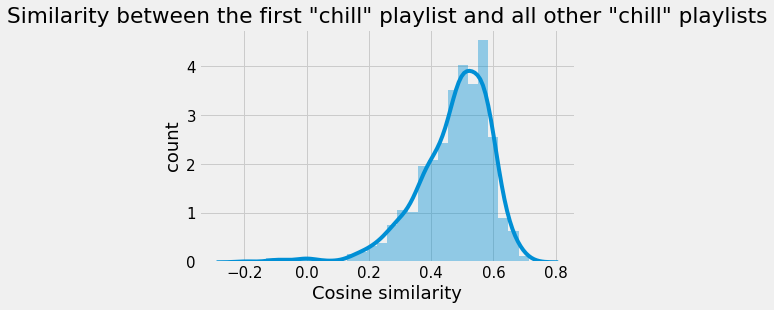

In [84]:
fig,ax = plt.subplots(1,1)
sns.distplot([similarity(playlist_weights, 67, x) for x in chill_idx[1:]], ax = ax)
plt.title("Similarity between the first \"chill\" playlist and all other \"chill\" playlists")
plt.xlabel("Cosine similarity")
plt.ylabel("count")

In [109]:
find_similar(67,playlist_weights, "playlist")

Playlists closest to chill.

Playlist: chill        (67) Similarity: 1.0
Playlist: Summer Jams  (51878) Similarity: 0.89
Playlist: Turnt        (9544) Similarity: 0.88
Playlist: RUNNING      (27943) Similarity: 0.88
Playlist: spin         (84570) Similarity: 0.88
Playlist: shower       (42009) Similarity: 0.88
Playlist: abs          (22057) Similarity: 0.87
Playlist: swerve       (90827) Similarity: 0.87
Playlist: old hits     (7339) Similarity: 0.87
Playlist: Gym          (52897) Similarity: 0.87


In [110]:
find_similar(67,playlist_weights_test, "playlist")

Playlists closest to chill.

Playlist: chill        (67) Similarity: 1.0
Playlist: Summer Jams  (51878) Similarity: 0.89
Playlist: Turnt        (9544) Similarity: 0.88
Playlist: RUNNING      (27943) Similarity: 0.88
Playlist: spin         (84570) Similarity: 0.88
Playlist: shower       (42009) Similarity: 0.88
Playlist: abs          (22057) Similarity: 0.87
Playlist: swerve       (90827) Similarity: 0.87
Playlist: old hits     (7339) Similarity: 0.87
Playlist: Gym          (52897) Similarity: 0.87


In [373]:
for track, name in track_name.items():
    if (name.lower() == "innocence"):
        print(track, track_artist[track])

spotify:track:3PIVUj3TjaFKKhzrVFhlx6 Flume
spotify:track:2l3HG6PI29cx7yRdWDugCx Omar Sosa
spotify:track:2wcOAWdnv22pYwRHscYfz2 Halestorm
spotify:track:2pdEafpOw3Jvddrm2by0NR NERO
spotify:track:4cf8d3h8m5LzIlDlDarDcA SVDKO
spotify:track:5XJPiKQ1dDQBRC9QzXTrn5 Madeon
spotify:track:0Fp2uHh3SMMvI4uVjO6WKv WMD
spotify:track:1njBM4jbjCpMAOpolEmgsL Björk
spotify:track:1FqthqP6Ln91pUXtW7yEW8 The Airborne Toxic Event
spotify:track:0gim01kKtr7rfWhb2CtvDx Roy Woods
spotify:track:0dSqYcX6QIi4Tmm3NljthH Disturbed
spotify:track:5BwMH8hG9Q2umLawuEYfY7 Preservation Hall Jazz Band
spotify:track:3nqD0seGRCJCePIZcg9DuQ Cat Trumpet
spotify:track:7ic4MobV8clDXnYmJ0fRYh Avril Lavigne
spotify:track:3ZgXhAgwV3ek3UGz8ON8FK Electric Youth
spotify:track:0TkO8q9FmS2Ia33c2lFOS1 Rebekka Bakken
spotify:track:6bso1htHAimZOrJ6y4lp17 Jóhann Jóhannsson
spotify:track:4YEzNeBZbfP5nAChuwH10E Sarah Buxton
spotify:track:5zW8p9nOndsKZnhes6PJtM Kenny G
spotify:track:5WcUYRo77gosbOZbHrow9c Jeremy Camp
spotify:track:0Bc8dR10Jc3m

In [111]:
similarity(track_weights, track_idx["spotify:track:1UZOjK1BwmwWU14Erba9CZ"], track_idx["spotify:track:1zqllQUMCgMaInr0CzFVll"])

0.34829685

In [374]:
find_similar(track_idx["spotify:track:7ic4MobV8clDXnYmJ0fRYh"],track_weights, "track",20)

Tracks closest to Innocence.

Track: Innocence                             (624834) Similarity: 1.0
Track: Garuna                                (308677) Similarity: 0.67
Track: Ciganysoron nem merek eljarni (I Don't Care to Go Along the Gypsy Row)(640653) Similarity: 0.66
Track: Psalm 122: I was glad - ;1989 Remastered Version(127036) Similarity: 0.65
Track: Tu Tiempo Ya Se Fue                   (7353) Similarity: 0.64
Track: Hammer on The Flag                    (41856) Similarity: 0.64
Track: Four Swans Dance                      (468311) Similarity: 0.64
Track: All Stars - Workout Remix 140 Bpm     (287749) Similarity: 0.64
Track: Mia Mera Tha To Po - Live             (5007) Similarity: 0.63
Track: Daylight Outro (Remix)                (627318) Similarity: 0.63
Track: Amor De Antigos                       (224407) Similarity: 0.63
Track: C'mon Children                        (422796) Similarity: 0.63
Track: New Rules - Acoustic                  (319752) Similarity: 0.63
Track: Old 

In [115]:
find_similar(track_idx["spotify:track:7xrfxCMzWhqwjvI0W50EHA"],track_weights, "track",20)

Tracks closest to City Of Stars.

Track: City Of Stars                         (230486) Similarity: 1.0
Track: Next to Me                            (94865) Similarity: 0.77
Track: Why Is It So Hard                     (19571) Similarity: 0.74
Track: Let It Be                             (634744) Similarity: 0.74
Track: Baku (Dinka Remix) [feat. Chinar]     (124312) Similarity: 0.74
Track: Praise                                (536510) Similarity: 0.74
Track: She Knows                             (440463) Similarity: 0.73
Track: Future                                (666943) Similarity: 0.73
Track: Keep My Head High                     (448851) Similarity: 0.73
Track: Drop Top Music (feat. Rick Ross)      (568688) Similarity: 0.73
Track: Come Closer                           (139653) Similarity: 0.73
Track: Devuelveme La Vida                    (153095) Similarity: 0.73
Track: Turnaroundturnmeon                    (131486) Similarity: 0.73
Track: Flyg vilda fågel                      (

In [409]:
find_similar(track_idx["spotify:track:0tgVpDi06FyKpA1z0VMD4v"],track_weights, "track", 10)

Tracks closest to Perfect.

Track: Perfect                               (63377) Similarity: 1.0
Track: Unsteady                              (140640) Similarity: 0.91
Track: All We Got (feat. Kanye West & Chicago Children's Choir)(379867) Similarity: 0.91
Track: Thinking Out Loud                     (254513) Similarity: 0.91
Track: Shut Up and Dance                     (306052) Similarity: 0.91
Track: Halo                                  (351553) Similarity: 0.91
Track: FourFiveSeconds                       (613343) Similarity: 0.91
Track: Hello                                 (549109) Similarity: 0.91
Track: Hands To Myself                       (268034) Similarity: 0.9
Track: Only Girl (In The World)              (553358) Similarity: 0.9


In [410]:
np.flip(b)

array([ 63377, 140640, 379867, 254513, 306052, 351553, 613343, 549109,
       268034, 553358, 503268, 374978, 271418, 434925,  17100, 429030,
       446180, 530785, 671793, 166428])

In [383]:
track_name[idx_track[b[0]]]

'Stitches'

In [379]:
find_similar(0,track_weights, "track",20)

Tracks closest to 10 (feat. Starxs).

Track: 10 (feat. Starxs)                     (0) Similarity: 1.0
Track: In A Mellow Tone                      (244968) Similarity: 0.71
Track: Walk the Line                         (278126) Similarity: 0.71
Track: Barefoot Winter Waltz                 (497837) Similarity: 0.69
Track: Beautiful Soul / Khabar Nahi - Remastered(251445) Similarity: 0.69
Track: Every Day Is War                      (126772) Similarity: 0.69
Track: Sons of War                           (444813) Similarity: 0.69
Track: Day Day (feat. Jay Park)              (491187) Similarity: 0.69
Track: Roving Gambler                        (320734) Similarity: 0.69
Track: One More Miracle                      (573625) Similarity: 0.69
Track: Just a Touch of Love                  (169536) Similarity: 0.69
Track: The Streetz R Deathrow                (92705) Similarity: 0.68
Track: Odiame Pero No Me Dejes               (320754) Similarity: 0.68
Track: These Are The Days - Radio Edit     

In [217]:
plot_weights = track_weights[list(idx_genre_include.keys()),:]

In [216]:
colors = list(idx_genre_include.values())
colors = pd.factorize(colors)

In [249]:
sample_idx = random.sample(range(colors[0].shape[0]), 20000)
plot_weights_sample = plot_weights[sample_idx,:]
colors_sample = colors[0][sample_idx,]

In [277]:
from sklearn.decomposition import PCA
plot_weights_reduced = PCA(2).fit_transform(plot_weights_sample)

In [262]:
track_features = pd.read_csv("tracks_features_info.csv")

In [ ]:
dist, closest = find_similar(track_idx[])

## Design Recommendation System based on Embeddings of Tracks

In [455]:
def Recommend_Songs(weights, trackid_list):
    n = len(trackid_list)
    id_dist = {}
    for track in trackid_list:
        dist, closest = find_similar(track_idx[track], weights, n=10, return_dist = True)
        closest = np.flip(closest)
        for i in closest[1:]:
            if (i in id_dist.keys()):
                id_dist[i] = max(id_dist[i], dist[i])
            else:
                id_dist[i] = dist[i]
    id_dist = {i:v for i,v in sorted(id_dist.items(), key=lambda item: item[1])}
    recommend_track_list = [idx_track[x] for x in id_dist.keys()]
    recommend_track_list = [track for track in recommend_track_list if track not in trackid_list]
    return recommend_track_list[-n:]

In [412]:
[track_name[i] for i in Recommend_Songs(track_weights, trackid_list)]

['Thinking Out Loud',
 "All We Got (feat. Kanye West & Chicago Children's Choir)",
 'Unsteady']

In [420]:
playlist_idx = random.sample(list(playlist_dict.keys()), 1000)

In [467]:
train_playlist = []
test_playlist = []
for idx in playlist_idx:
    train, test = train_test_split((np.array(playlist_dict[0][1])[:,0]).tolist(), test_size = 0.2)
    train_playlist.append(train)
    test_playlist.append(test)

In [ ]:
recommend_playlist = []
for i in range(100):
    recommend_playlist.append(Recommend_Songs(track_weights, train_playlist[i]))

In [457]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

In [461]:
overlap = []
overlap_count = []
overlap_proportion = []
for i in range(10):
    intersect = intersection(recommend_playlist[i], test_playlist[i])
    overlap_count.append(len(intersect))
    overlap.append(intersect)
    overlap_proportion.append(len(intersect)/len(test_playlist[i]))

In [462]:
overlap_proportion

[0.09090909090909091,
 0.18181818181818182,
 0.2727272727272727,
 0.2727272727272727,
 0.18181818181818182,
 0.18181818181818182,
 0.18181818181818182,
 0.18181818181818182,
 0.18181818181818182,
 0.09090909090909091]

In [463]:
intersection(recommend_playlist[0], test_playlist[0])

['spotify:track:1lzr43nnXAijIGYnCT8M8H']

In [464]:
overlap_count

[1, 2, 3, 3, 2, 2, 2, 2, 2, 1]

In [465]:
train_playlist = []